In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import random
import os

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense,Dropout, LeakyReLU
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.glove_word_embedding_generator import GloveWordEmbeddingGenerator
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.metrics import rmse
from lib.model.search.greedy_search_strategy import GreedySearchStrategy
from lib.model.search.beam_search_strategy import BeamSearchStrategy, EndCriteria
from lib.model.attention_layer import AttentionLayer

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory
from lib.utils.plot_utils import show_sample
from lib.utils.array_utils import column
from lib.utils.pickle_utils import save_obj, load_obj
from lib.utils.sequencer import Sequencer

from keras.callbacks                         import ModelCheckpoint
from lib.callback.metric_plotter             import MetricsPlotter
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker
from keras.callbacks                         import ReduceLROnPlateau

from lib.model.prediction_inspector import PredictionInspector

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset_name='8k'
# dataset_name='30k'

embedding_vector_dim = 300
embedding_token_count = 6
embedding_token_count = 840
embeding_name = f'{embedding_token_count}B.{embedding_vector_dim}d'
word_embedding_path = f'./dataset/glove.{embeding_name}.txt'



dataset_path=f'./dataset/{dataset_name}'
data_path = f'{dataset_path}/data'
images_path = f'{dataset_path}/images'

image_features_path = f'{dataset_path}/img_features.pkl'
descrption_embedding_path = f'{dataset_path}/descrition_embeding.{embeding_name}.pkl'

line_separator = { 
    '8k': r'#[0-9]',
    '30k': r'\| [0-9]\|'
}
weights_path = create_directory(f'weights/{dataset_name}')
weights_file_path_patern = weights_path + '/weights__epoch_{epoch:02d}__loss_{val_loss:.4f}__acc_{val_rmse:.4f}.h5'

In [4]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True,
    separator=line_separator[dataset_name]
)

Max len desc: $ an africanamerican man wear green sweatshirt and blue vest be hold up dollar bill in front of his face while stand on busy sidewalk in front of group of man play instrument #


In [5]:
train_samples, remain_samples = train_test_split(dataset.samples(), test_size=0.16, shuffle=True)
val_samples, test_samples = train_test_split(remain_samples, test_size=0.22, shuffle=True)

print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 6796, Val: 1010, Test: 285


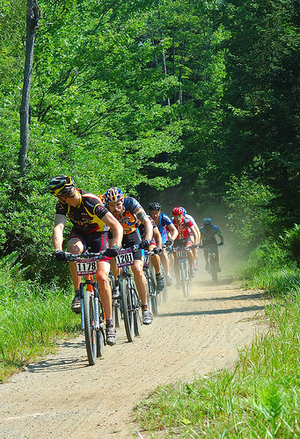

Description
0  group of bicyclist ride down path in an off road race
1                   group of biker ride through the wood
2                group of person be ride bicycle in race
3                              biker race through forest
4                    many bicyclist race along dirt road

In [6]:
show_sample(train_samples[0])

In [7]:
if not os.path.isfile(image_features_path):
    image_paths = dataset.samples(col=0)
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    save_obj(image_features_path, image_features)

image_features = load_obj(image_features_path)
print(image_features[0])
image_features = dict(image_features)

('./dataset/8k/images/1305564994_00513f9a5b.jpg', array([ 0.06508789,  0.03218704,  0.02376981, ...,  0.38368699,
        0.19910596,  0.23510453], dtype=float32))


In [8]:
min_occurs=10

vocabulary = dataset.words_set(min_occurs=10)
vocabulary_size = len(vocabulary)
complete_vocabulary_size = len(dataset.words_set())
print(f'Words(occurs>={min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1593/6688


In [9]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

In [10]:
len(word_to_index)

1593

In [11]:
dataset.max_desc_len()

174

In [12]:
if not os.path.isfile(descrption_embedding_path):
    embedding_generator = GloveWordEmbeddingGenerator(word_embedding_path, embedding_vector_dim)
    embedding_matrix = embedding_generator.generate(word_to_index)
    save_obj(descrption_embedding_path, embedding_matrix)

embedding_matrix = load_obj(descrption_embedding_path)
len(embedding_matrix)

1593

In [13]:
def build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, optimizer):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))

    img_branch = Dropout(0.5)(img_feat_input)
    img_branch = Dense(512)(img_branch)
    img_branch = LeakyReLU(alpha=0.3)(img_branch)

    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))

    seq_branch = Embedding(vocabulary_size, embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(0.5)(seq_branch)
    seq_branch = LSTM(512)(seq_branch)

    decoder = add([img_branch, seq_branch])
    decoder = Dense(512)(decoder)
    decoder = LeakyReLU(alpha=0.3)(decoder)
    
    outputs = Dense(name="Words_Distribution", units=vocabulary_size, activation='softmax')(decoder)

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)

    model.layers[3].set_weights([embedding_matrix])
    model.layers[3].trainable = False

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=[rmse]
    )

    return ModelWrapper(model)

In [14]:
# 1ª Train:
epochs=10
lr=0.001
batch_size = 12

# 2ª Train:
#epochs=10
#lr=0.0001
#batch_size = 20

steps_per_epoch=len(train_samples)/batch_size

In [15]:
train_generator = DataGenerator(
    train_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

val_generator = DataGenerator(
    val_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

In [16]:
callbacks = [
    ModelCheckpoint(
        weights_file_path_patern,
        monitor='val_loss', 
        verbose=1,
        save_best_only=True, 
        save_weights_only=True, 
        mode='auto',
        period=1
    ),
    AdamLearningRateTracker(evaluate_interval=105),
    ReduceLROnPlateau(
        monitor  = 'val_loss',
        factor   = 0.2,
        patience = 1
    ),
    MetricsPlotter(
        val_generator, 
        plot_interval=100, 
        evaluate_interval=100, 
        batch_size=batch_size
    )
]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Metrics: ['loss', 'rmse']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Feature (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
Description_Sequence (InputLaye (None, 174)          0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           Image_Feature[0][0]              
____________________________________________________________________________________________

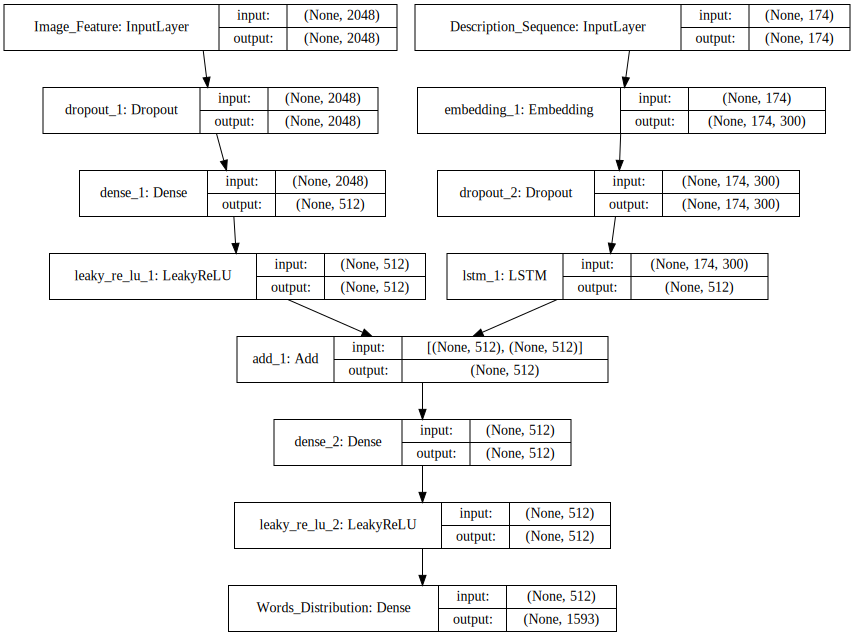

In [17]:
model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, Adam(lr=lr))
model.show()    

In [18]:
model.load(f'{weights_path}/weights__epoch_01__loss_2.3339__acc_0.0210.h5')

# model.fit(train_generator, val_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

Load weights from weights/8k/weights__epoch_01__loss_2.3339__acc_0.0210.h5


In [43]:
sequencer = Sequencer(
    word_to_index=word_to_index,
    index_to_word=index_to_word,
    max_seq_len=dataset.max_desc_len()
)

search = BeamSearchStrategy(
    model=model,
    sequencer=sequencer,
    seq_prefix='$',
    seq_postfix='#',
    end_criteria=EndCriteria().at_lest_n_end_with(n=5, word='#'),
    k=5
)

def random_sample(samples): return samples[random.randint(0, len(samples)-1)]

inspector = PredictionInspector(search, image_features, dataset.descriptions())

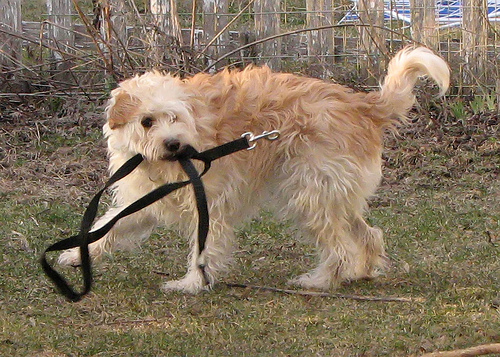

Predicted Description Description Score (⟱ best)  \
0   white dog be run through the grass               0.0417406447   
1                                                                   
2                                                                   
3                                                                   
4                                                                   
5      white dog run through the grass               0.0429402254   
6                                                                   
7                                                                   
8                                                                   
9                                                                   
10       white dog be run in the grass               0.0615993193   
11                                                                  
12                                                                  
13                                                                  
14                                                                  

   WMD Similarity Mean (⟰ best) WMD Similarity (⟰ best)  \
0                  0.6575677672            0.6736576479   
1                                          0.6684721677   
2                                          0.6618263075   
3                                          0.6467924987   
4                                          0.6370902142   
5                  0.6575677672            0.6736576479   
6                                          0.6684721677   
7                                          0.6618263075   
8                                          0.6467924987   
9                                          0.6370902142   
10                 0.6575677672            0.6736576479   
11                                         0.6684721677   
12                                         0.6618263075   
13                                         0.6467924987   
14                                         0.6370902142   

                                       Sample Description  
0                            yellow dog carry black leash  
1               fluffy dog carry black leash in its mouth  
2                            dog carry leash in its mouth  
3                    dog walk with his lease in his mouth  
4   large furry brown dog be walk with leash in his mouth  
5                            yellow dog carry black leash  
6               fluffy dog carry black leash in its mouth  
7                            dog carry leash in its mouth  
8                    dog walk with his lease in his mouth  
9   large furry brown dog be walk with leash in his mouth  
10                           yellow dog carry black leash  
11              fluffy dog carry black leash in its mouth  
12                           dog carry leash in its mouth  
13                   dog walk with his lease in his mouth  
14  large furry brown dog be walk with leash in his mouth

In [66]:
inspector.inspect(random_sample(test_samples))

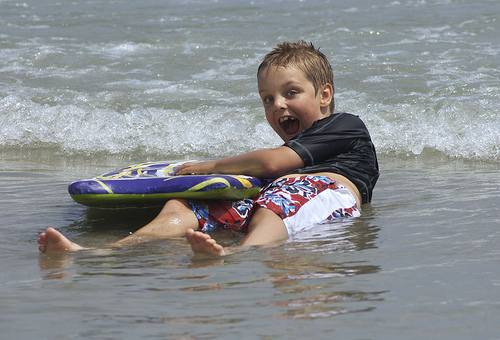

Predicted Description Description Score (⟱ best)  \
0       person in life jacket be surf in the ocean               0.1143472211   
1                                                                               
2                                                                               
3                                                                               
4                                                                               
5       person in life jacket be surf in the water               0.2258935751   
6                                                                               
7                                                                               
8                                                                               
9                                                                               
10  young boy in swim trunk be boogie in the water               0.7241993750   
11                                                                              
12                                                                              
13                                                                              
14                                                                              

   WMD Similarity Mean (⟰ best) WMD Similarity (⟰ best)  \
0                  0.5927845446            0.6035565010   
1                                          0.6026664739   
2                                          0.5904048761   
3                                          0.5841145317   
4                                          0.5831803401   
5                  0.5836727967            0.6031142480   
6                                          0.5943356977   
7                                          0.5939977275   
8                                          0.5762854914   
9                                          0.5506308188   
10                 0.6692785612            0.7433203505   
11                                         0.6706560913   
12                                         0.6590098186   
13                                         0.6498907646   
14                                         0.6235157811   

                                                                   Sample Description  
0   smile young boy wear bathe suit be hold surfboard and lay down in the ocean water  
1                                                      young boy with blue body board  
2                              young boy hold his boogie board in shallow ocean water  
3                                     an excited boy play in the surf with body board  
4                                             boy play in the ocean with boogie board  
5   smile young boy wear bathe suit be hold surfboard and lay down in the ocean water  
6                                                      young boy with blue body board  
7                              young boy hold his boogie board in shallow ocean water  
8                                     an excited boy play in the surf with body board  
9                                             boy play in the ocean with boogie board  
10                             young boy hold his boogie board in shallow ocean water  
11                                                     young boy with blue body board  
12                                            boy play in the ocean with boogie board  
13  smile young boy wear bathe suit be hold surfboard and lay down in the ocean water  
14                                    an excited boy play in the surf with body board

In [67]:
inspector.inspect(random_sample(test_samples))

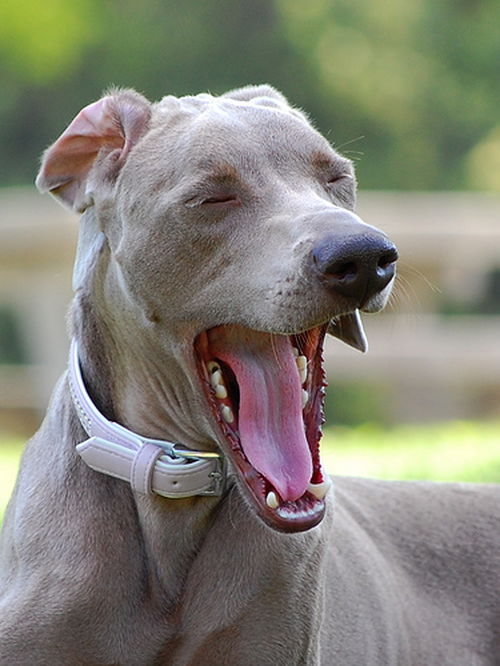

Predicted Description Description Score (⟱ best)  \
0      brown dog run through the grass               0.1317726258   
1                                                                   
2                                                                   
3                                                                   
4                                                                   
5   brown dog be run through the grass               0.1334785474   
6                                                                   
7                                                                   
8                                                                   
9                                                                   
10       tan dog run through the grass               0.1608720506   
11                                                                  
12                                                                  
13                                                                  
14                                                                  

   WMD Similarity Mean (⟰ best) WMD Similarity (⟰ best)  \
0                  0.6351656109            0.6741672658   
1                                          0.6454233858   
2                                          0.6262029180   
3                                          0.6176836107   
4                                          0.6123508740   
5                  0.6351656109            0.6741672658   
6                                          0.6454233858   
7                                          0.6262029180   
8                                          0.6176836107   
9                                          0.6123508740   
10                 0.6303458642            0.6676733480   
11                                         0.6397989621   
12                                         0.6209070377   
13                                         0.6157266154   
14                                         0.6076233577   

                                  Sample Description  
0                         dog with white collar yawn  
1                                   gray dog be yawn  
2                        gray dog have its eye close  
3                               dog wear collar yawn  
4   gray dog in white collar yawn with its eye close  
5                         dog with white collar yawn  
6                                   gray dog be yawn  
7                        gray dog have its eye close  
8                               dog wear collar yawn  
9   gray dog in white collar yawn with its eye close  
10                        dog with white collar yawn  
11                                  gray dog be yawn  
12                       gray dog have its eye close  
13                              dog wear collar yawn  
14  gray dog in white collar yawn with its eye close

In [68]:
inspector.inspect(random_sample(test_samples))

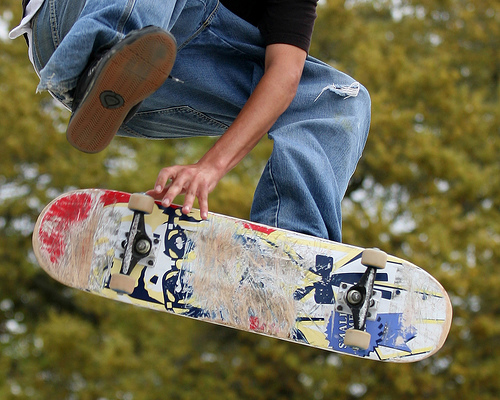

Predicted Description Description Score (⟱ best)  \
0   skateboarder do trick on half pipe               0.0078422389   
1                                                                   
2                                                                   
3                                                                   
4                                                                   
5        skateboarder do trick on ramp               0.0122491628   
6                                                                   
7                                                                   
8                                                                   
9                                                                   
10    skateboarder do trick in the air               0.0454646100   
11                                                                  
12                                                                  
13                                                                  
14                                                                  

   WMD Similarity Mean (⟰ best) WMD Similarity (⟰ best)  \
0                  0.6472454511            0.7667279854   
1                                          0.6768306918   
2                                          0.6461250774   
3                                          0.5806382822   
4                                          0.5659052186   
5                  0.6812259407            0.8893434194   
6                                          0.7833598882   
7                                          0.6757130272   
8                                          0.5309154999   
9                                          0.5267978688   
10                 0.6498780927            0.8277539065   
11                                         0.6856255741   
12                                         0.6304561550   
13                                         0.5751932974   
14                                         0.5303615304   

                                                                    Sample Description  
0                                                   skateboarder be do trick in midair  
1                                                         he be do trick on skateboard  
2                                                        person do trick on skateboard  
3   there be the bottom of skateboard off the ground with someone in blue jean hold it  
4              this skateboarder wear jean and tennis shoe grab board while in the air  
5                                                   skateboarder be do trick in midair  
6                                                         he be do trick on skateboard  
7                                                        person do trick on skateboard  
8   there be the bottom of skateboard off the ground with someone in blue jean hold it  
9              this skateboarder wear jean and tennis shoe grab board while in the air  
10                                                  skateboarder be do trick in midair  
11                                                        he be do trick on skateboard  
12                                                       person do trick on skateboard  
13             this skateboarder wear jean and tennis shoe grab board while in the air  
14  there be the bottom of skateboard off the ground with someone in blue jean hold it

In [69]:
inspector.inspect(random_sample(test_samples))

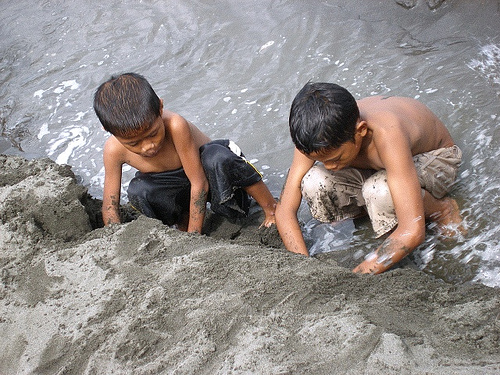

Predicted Description Description Score (⟱ best)  \
0   young boy play in the sand at beach               0.0061435746   
1                                                                    
2                                                                    
3                                                                    
4                                                                    
5                child play in the sand               0.0256817545   
6                                                                    
7                                                                    
8                                                                    
9                                                                    
10           young boy play in the sand               0.0580580479   
11                                                                   
12                                                                   
13                                                                   
14                                                                   

   WMD Similarity Mean (⟰ best) WMD Similarity (⟰ best)  \
0                  0.6996257054            0.7804211355   
1                                          0.7425068505   
2                                          0.7373397781   
3                                          0.6647148648   
4                                          0.5731458979   
5                  0.6300049874            0.7082797423   
6                                          0.6841794012   
7                                          0.6173183526   
8                                          0.5780445167   
9                                          0.5622029240   
10                 0.6949346940            0.8233325177   
11                                         0.7422027090   
12                                         0.7153702493   
13                                         0.6449918687   
14                                         0.5487761251   

                                            Sample Description  
0                                  two boy be play in wet sand  
1             two skinny young boy play with sand in the water  
2                                     two boy play in the sand  
3               two young boy sit in water and dig in the sand  
4   child be near large pile of sand that be next to the water  
5                                     two boy play in the sand  
6                                  two boy be play in wet sand  
7             two skinny young boy play with sand in the water  
8   child be near large pile of sand that be next to the water  
9               two young boy sit in water and dig in the sand  
10                                    two boy play in the sand  
11                                 two boy be play in wet sand  
12            two skinny young boy play with sand in the water  
13              two young boy sit in water and dig in the sand  
14  child be near large pile of sand that be next to the water

In [70]:
inspector.inspect(random_sample(test_samples))

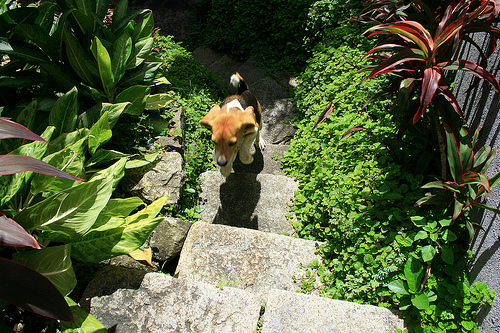

Predicted Description  \
0     person be sit on brick step in front of some plant   
1                                                          
2                                                          
3                                                          
4                                                          
5     person be sit on brick step in front of brick wall   
6                                                          
7                                                          
8                                                          
9                                                          
10  person be sit on brick step in front of flower plant   
11                                                         
12                                                         
13                                                         
14                                                         

   Description Score (⟱ best) WMD Similarity Mean (⟰ best)  \
0                0.0000450350                 0.6049167134   
1                                                            
2                                                            
3                                                            
4                                                            
5                0.0000455438                 0.5708588042   
6                                                            
7                                                            
8                                                            
9                                                            
10               0.0000567305                 0.6083768212   
11                                                           
12                                                           
13                                                           
14                                                           

   WMD Similarity (⟰ best)                              Sample Description  
0             0.6331988386   dog begin to climb brick staircase near plant  
1             0.6282386924         dog climb stone stair surround by plant  
2             0.6210653300                       dog climb step near plant  
3             0.5838614768  small dog go up concrete stair near many plant  
4             0.5582192291                    dog run up some outdoor step  
5             0.5937981189   dog begin to climb brick staircase near plant  
6             0.5906319406         dog climb stone stair surround by plant  
7             0.5792216169                       dog climb step near plant  
8             0.5533291539  small dog go up concrete stair near many plant  
9             0.5373131907                    dog run up some outdoor step  
10            0.6346166205   dog begin to climb brick staircase near plant  
11            0.6194853932                       dog climb step near plant  
12            0.6162459568         dog climb stone stair surround by plant  
13            0.6002077701  small dog go up concrete stair near many plant  
14            0.5713283656                    dog run up some outdoor step

In [71]:
inspector.inspect(random_sample(test_samples))

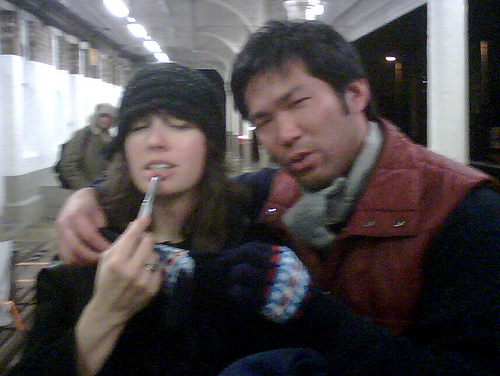

Predicted Description Description Score (⟱ best)  \
0            man and woman look at each other               0.0026744595   
1                                                                          
2                                                                          
3                                                                          
4                                                                          
5   man and woman look at each other    while               0.0173405157   
6                                                                          
7                                                                          
8                                                                          
9                                                                          
10     man and woman look at each other    on               0.0195842966   
11                                                                         
12                                                                         
13                                                                         
14                                                                         

   WMD Similarity Mean (⟰ best) WMD Similarity (⟰ best)  \
0                  0.6348176952            0.7025996321   
1                                          0.6655686996   
2                                          0.6479448769   
3                                          0.6071661618   
4                                          0.5508091056   
5                  0.6348176952            0.7025996321   
6                                          0.6655686996   
7                                          0.6479448769   
8                                          0.6071661618   
9                                          0.5508091056   
10                 0.6348176952            0.7025996321   
11                                         0.6655686996   
12                                         0.6479448769   
13                                         0.6071661618   
14                                         0.5508091056   

                                                         Sample Description  
0                                             blurry photo of man and woman  
1                                man in woman dress warmly pose for picture  
2                man and woman pose for picture together with neither smile  
3   man have is arm around woman who be hold metallic object up to her face  
4                                     couple wear winter coat pose together  
5                                             blurry photo of man and woman  
6                                man in woman dress warmly pose for picture  
7                man and woman pose for picture together with neither smile  
8   man have is arm around woman who be hold metallic object up to her face  
9                                     couple wear winter coat pose together  
10                                            blurry photo of man and woman  
11                               man in woman dress warmly pose for picture  
12               man and woman pose for picture together with neither smile  
13  man have is arm around woman who be hold metallic object up to her face  
14                                    couple wear winter coat pose together

In [72]:
inspector.inspect(random_sample(test_samples))

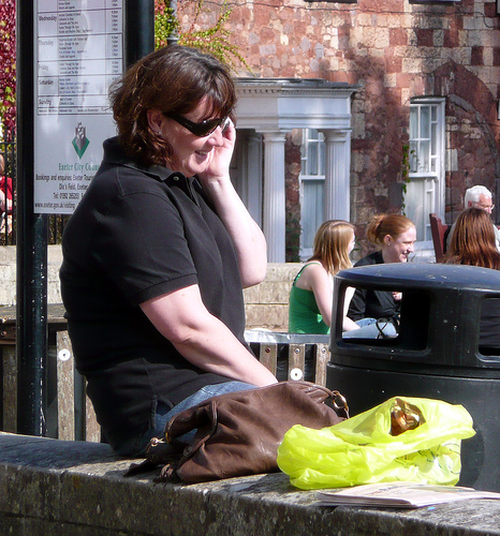

Predicted Description  \
0     young girl be sit on sidewalk in front of building   
1                                                          
2                                                          
3                                                          
4                                                          
5       young girl be sit on sidewalk in front of street   
6                                                          
7                                                          
8                                                          
9                                                          
10  young girl be sit on sidewalk in front of brick wall   
11                                                         
12                                                         
13                                                         
14                                                         

   Description Score (⟱ best) WMD Similarity Mean (⟰ best)  \
0                0.0006073847                 0.6178204071   
1                                                            
2                                                            
3                                                            
4                                                            
5                0.0007236251                 0.5986254447   
6                                                            
7                                                            
8                                                            
9                                                            
10               0.0009262790                 0.6364348143   
11                                                           
12                                                           
13                                                           
14                                                           

   WMD Similarity (⟰ best)  \
0             0.6727187864   
1             0.6374381474   
2             0.6342607926   
3             0.5757055370   
4             0.5689787725   
5             0.6182903551   
6             0.6150510717   
7             0.6092442832   
8             0.5854300028   
9             0.5651115106   
10            0.7117573528   
11            0.7002063557   
12            0.6182545830   
13            0.5776537436   
14            0.5743020363   

                                                                 Sample Description  
0                              woman with backpack sit outside building with others  
1                                     woman sit on stone wall and talk on her phone  
2                 this woman be smile and talk on the phone while sit on stone wall  
3                          woman in black shirt be sit next to florescent green bag  
4   woman speak on her cellphone with her purse and yellow bag on ledge next to her  
5                                     woman sit on stone wall and talk on her phone  
6                 this woman be smile and talk on the phone while sit on stone wall  
7                              woman with backpack sit outside building with others  
8                          woman in black shirt be sit next to florescent green bag  
9   woman speak on her cellphone with her purse and yellow bag on ledge next to her  
10                this woman be smile and talk on the phone while sit on stone wall  
11                                    woman sit on stone wall and talk on her phone  
12                             woman with backpack sit outside building with others  
13                         woman in black shirt be sit next to florescent green bag  
14  woman speak on her cellphone with her purse and yellow bag on ledge next to her

In [73]:
inspector.inspect(random_sample(test_samples))

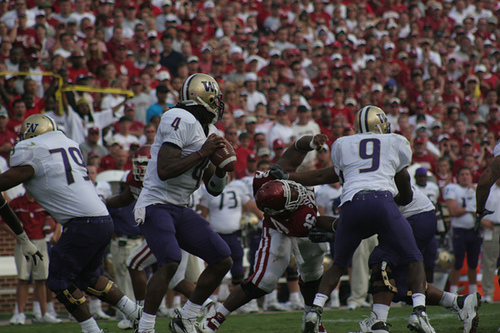

Predicted Description  \
0   football player in red and white uniform be tackle by player in white   
1                                                                           
2                                                                           
3                                                                           
4                                                                           
5     football player in red and white uniform be tackle by player in red   
6                                                                           
7                                                                           
8                                                                           
9                                                                           
10       football player in red be tackle player in red and white uniform   
11                                                                          
12                                                                          
13                                                                          
14                                                                          

   Description Score (⟱ best) WMD Similarity Mean (⟰ best)  \
0                0.0010642767                 0.5969882001   
1                                                            
2                                                            
3                                                            
4                                                            
5                0.0014322516                 0.5948927668   
6                                                            
7                                                            
8                                                            
9                                                            
10               0.0015206009                 0.5948927668   
11                                                           
12                                                           
13                                                           
14                                                           

   WMD Similarity (⟰ best)  \
0             0.6222233881   
1             0.6189600896   
2             0.5909953148   
3             0.5774081013   
4             0.5753541069   
5             0.6198274200   
6             0.6152274560   
7             0.5891208881   
8             0.5766173380   
9             0.5736707320   
10            0.6198274200   
11            0.6152274560   
12            0.5891208881   
13            0.5766173380   
14            0.5736707320   

                                                          Sample Description  
0                                  group of football player be play football  
1                                quarterback get ready to throw the football  
2               quarterback ready to pass the football in the middle of play  
3              there be notre dame quarterback drop back into pocket at game  
4   quarterback scan the football field while the offensive line protect him  
5                                  group of football player be play football  
6                                quarterback get ready to throw the football  
7               quarterback ready to pass the football in the middle of play  
8              there be notre dame quarterback drop back into pocket at game  
9   quarterback scan the football field while the offensive line protect him  
10                                 group of football player be play football  
11                               quarterback get ready to throw the football  
12              quarterback ready to pass the football in the middle of play  
13             there be notre dame quarterback drop back into pocket at game  
14  quarterback scan the football field while the offensive line protect him

In [74]:
inspector.inspect(random_sample(test_samples))

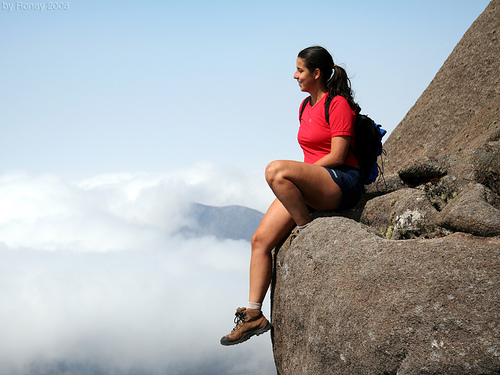

Predicted Description  \
0   person sit on the edge of cliff overlook the ocean   
1                                                        
2                                                        
3                                                        
4                                                        
5                 person sit on the edge of large rock   
6                                                        
7                                                        
8                                                        
9                                                        
10      person sit on the edge of large rock formation   
11                                                       
12                                                       
13                                                       
14                                                       

   Description Score (⟱ best) WMD Similarity Mean (⟰ best)  \
0                0.0001054994                 0.6135758668   
1                                                            
2                                                            
3                                                            
4                                                            
5                0.0005047229                 0.6186159839   
6                                                            
7                                                            
8                                                            
9                                                            
10               0.0005453355                 0.6325637033   
11                                                           
12                                                           
13                                                           
14                                                           

   WMD Similarity (⟰ best)  \
0             0.6645163148   
1             0.6235454075   
2             0.6129822544   
3             0.5910575436   
4             0.5757778138   
5             0.6695080657   
6             0.6159503483   
7             0.6095787724   
8             0.6011506741   
9             0.5968920588   
10            0.7025719569   
11            0.6208100438   
12            0.6186544986   
13            0.6128983159   
14            0.6078837013   

                                              Sample Description  
0                  woman in red be sit on the edge of steep rock  
1                 woman in red shirt be sit on the edge of cliff  
2            woman in red shirt be sit on the edge of high cliff  
3   girl sit on the side of large mountain with one leg hang off  
4              girl in red tshirt be sit on rock above the cloud  
5                  woman in red be sit on the edge of steep rock  
6                 woman in red shirt be sit on the edge of cliff  
7   girl sit on the side of large mountain with one leg hang off  
8              girl in red tshirt be sit on rock above the cloud  
9            woman in red shirt be sit on the edge of high cliff  
10                 woman in red be sit on the edge of steep rock  
11  girl sit on the side of large mountain with one leg hang off  
12                woman in red shirt be sit on the edge of cliff  
13             girl in red tshirt be sit on rock above the cloud  
14           woman in red shirt be sit on the edge of high cliff

In [75]:
inspector.inspect(random_sample(test_samples))

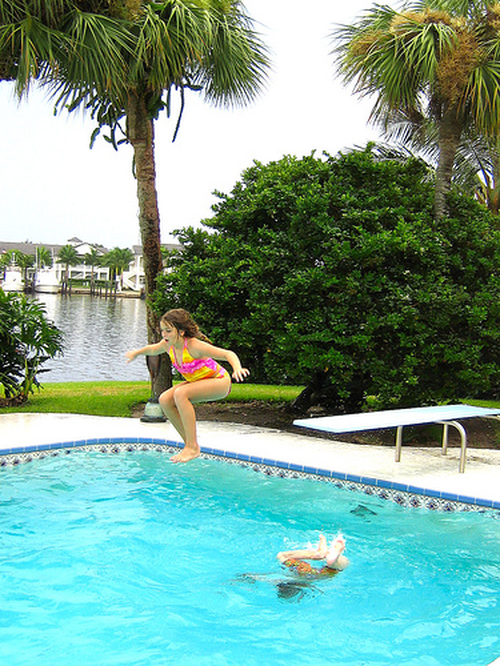

Predicted Description Description Score (⟱ best)  \
0   girl jump into pool in pool               0.0269836844   
1                                                            
2                                                            
3                                                            
4                                                            
5           girl jump into pool               0.0592750190   
6                                                            
7                                                            
8                                                            
9                                                            
10         child jump into pool               0.0645348399   
11                                                           
12                                                           
13                                                           
14                                                           

   WMD Similarity Mean (⟰ best) WMD Similarity (⟰ best)  \
0                  0.7547461108            0.8773765347   
1                                          0.7742278252   
2                                          0.7742278252   
3                                          0.7179804766   
4                                          0.6299178925   
5                  0.7353212708            0.8180727055   
6                                          0.7497994237   
7                                          0.7497994237   
8                                          0.7230603199   
9                                          0.6358744813   
10                 0.6692233039            0.7282648379   
11                                         0.6882140850   
12                                         0.6882140850   
13                                         0.6541815971   
14                                         0.5872419143   

                                                         Sample Description  
0                                                  girl jump into swim pool  
1                                       girl jump from dive board into pool  
2                                     girl jump off of dive board into pool  
3                              little girl be jump off dive board into pool  
4   young girl in pink and yellow bathe suit jump from dive board into pool  
5                                                  girl jump into swim pool  
6                                       girl jump from dive board into pool  
7                                     girl jump off of dive board into pool  
8                              little girl be jump off dive board into pool  
9   young girl in pink and yellow bathe suit jump from dive board into pool  
10                                                 girl jump into swim pool  
11                                      girl jump from dive board into pool  
12                                    girl jump off of dive board into pool  
13                             little girl be jump off dive board into pool  
14  young girl in pink and yellow bathe suit jump from dive board into pool

In [76]:
inspector.inspect(random_sample(test_samples))